# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
from geopandas.tools import overlay
import mapclassify as mc
import warnings
warnings.filterwarnings('ignore')

- The link where the data was downloaded is: http://insideairbnb.com/get-the-data/. 
- This dataset is specifically the listings in NYC. 
- The data columns can be explained when clicking on this link https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing. 
- Data used in this project was scraped on December 15, 2022.

# Loading and Preparing Dataset

In [3]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
# listingsNYC['price_bin'] = pd.cut(listingsNYC['price'], bins=range(0, 111, 10), right=False, labels=range(0, 110, 10))
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]
df['price_bin'] = pd.cut(df['price'], bins=range(0, 2001, 20), right=False, labels=range(0, 2000, 20))
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,pps,annual_revenue,log_price,log_pps,price_bin
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,...,0.03,1,267,1,NaN,5775,26950,5.616771,8.661294,260
1,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,...,0.73,1,0,0,NaN,150,27375,4.317488,5.010635,60
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.764570,-73.983170,Private room,68,...,3.38,1,79,50,NaN,136,19448,4.219508,4.912655,60
6,5803,"Lovely Room 1 in BEST AREA; Legal Rental, Spot...",9744,Laurie,Brooklyn,South Slope,40.668010,-73.987840,Private room,124,...,1.31,3,163,14,NaN,496,25048,4.820282,6.206576,120
8,7097,Perfect for Your Parents: Privacy + Garden,17571,Jane,Brooklyn,Fort Greene,40.691233,-73.972702,Entire home/apt,220,...,2.01,2,38,36,NaN,660,71940,5.393628,6.492240,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41525,772714221060214808,Good Vibes at The Bronx,421264574,Aridio,Bronx,Unionport,40.828074,-73.847886,Entire home/apt,125,...,NaN,1,60,0,NaN,250,38125,4.828314,5.521461,120
41526,772716724205003579,2 bedroom Condo near West Village,481177884,Steven,Manhattan,Chelsea,40.740030,-73.997302,Entire home/apt,1114,...,NaN,2,355,0,NaN,3342,11140,7.015712,8.114325,1100
41527,771961589340472067,Habitación Privada,409771624,Camila,Queens,Sunnyside,40.742223,-73.923310,Private room,124,...,NaN,1,360,0,NaN,248,620,4.820282,5.513429,120
41528,771962449581256963,Romántico y natural,421601513,Juan Carlos,Manhattan,Washington Heights,40.847271,-73.943419,Private room,80,...,NaN,3,358,0,NaN,400,560,4.382027,5.991465,80


# Visualizations

In [7]:
room_type_groups = df.groupby('room_type')
room_type_groups = room_type_groups[['price','pps']].mean()
room_type_groups=room_type_groups.reset_index()
room_type_groups.sort_values(by='price', ascending=False, inplace=True)

Text(0.5, 1.0, 'Barplot of Average Price for each Room Type')

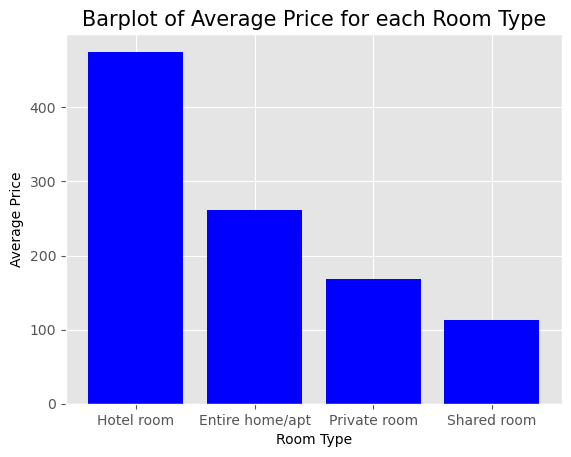

In [8]:
plt.bar(room_type_groups['room_type'], room_type_groups['price'], color='blue')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.title('Barplot of Average Price for each Room Type', fontsize = 15)

Text(0.5, 1.0, 'Histogram of Log Price')

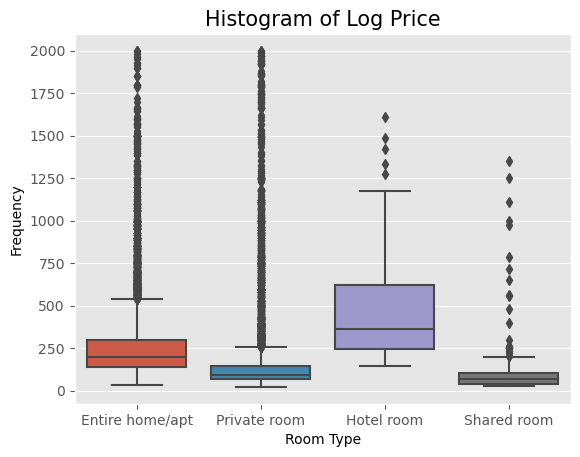

In [6]:
sns.boxplot(x = 'room_type', y = 'price', data = df)

plt.xlabel('Room Type')
plt.ylabel('Frequency')
plt.title('Histogram of Log Price', fontsize = 15)

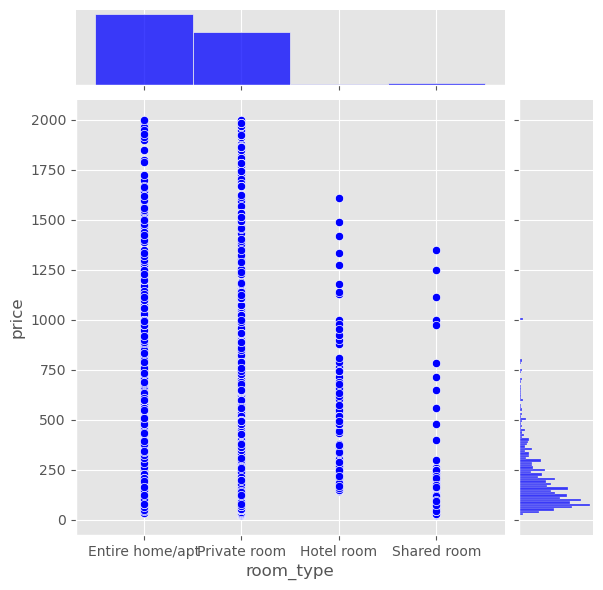

In [4]:
sns.jointplot(x = df['room_type'],y = df['price'], color='blue')

In [5]:
price_no_outlier = df.loc[(df['price'] - df['price'].mean()).abs() / df['price'].std() < 1]
price_no_outlier.shape

(19739, 23)

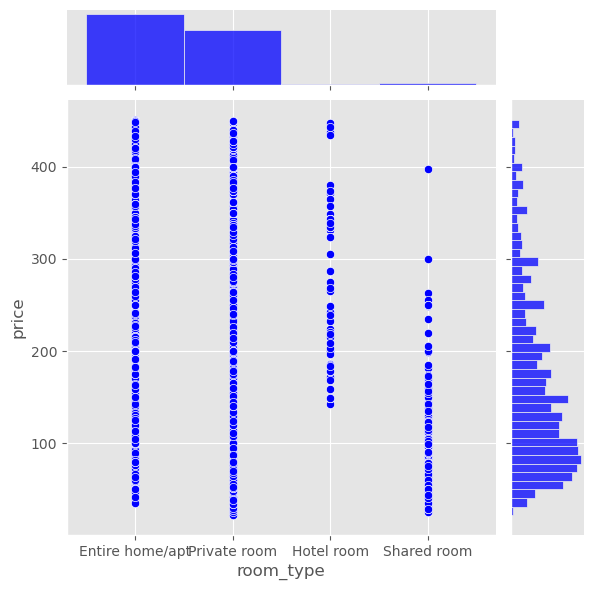

In [6]:
sns.jointplot(x = price_no_outlier['room_type'],y = price_no_outlier['price'], color='blue')

<AxesSubplot:xlabel='room_type', ylabel='price'>

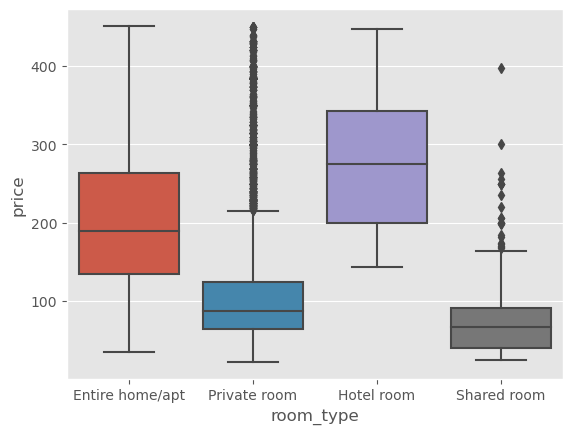

In [19]:
sns.boxplot(x = price_no_outlier['room_type'],y = price_no_outlier['price'])

In [24]:
# finding the mean price and price per night of each room_type
room_type_groups_no_outlier = price_no_outlier.groupby('room_type')
room_type_groups_no_outlier = room_type_groups_no_outlier[['price','pps']].mean()
room_type_groups_no_outlier=room_type_groups_no_outlier.reset_index()
room_type_groups_no_outlier.sort_values(by='price', ascending=False, inplace=True)

Text(0.5, 1.0, 'Barplot of Average Price for each Room Type (No Outliers)')

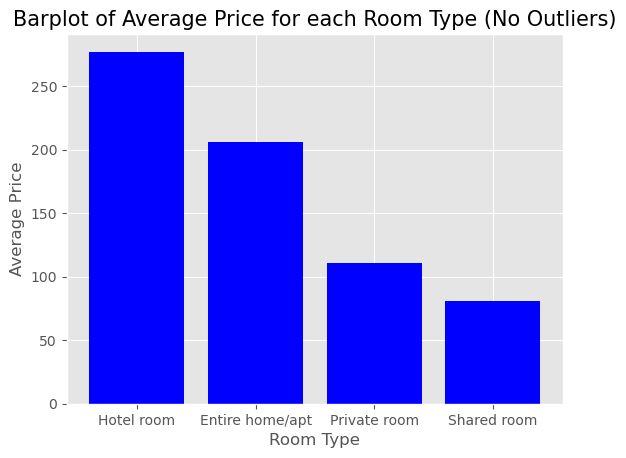

In [25]:
plt.bar(grouped_by_room_type['room_type'], grouped_by_room_type['price'], color='blue')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.title('Barplot of Average Price for each Room Type (No Outliers)', fontsize = 15)